In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Problem 1(a) and 1(b)
# Define actions (MOVE, TURN)
STILL = 0
FWDS = 1
BWDS = 2
NO_TURN = 0
LEFT_TURN = -1
RIGHT_TURN = 1

# Define the grid world
L = 6;
W = 6;

# State s = (x, y, h) including x coordinate, y coordinate and the heading h
S = []
for x in range(L):
    for y in range(W):
        for h in range(12):
            S.append((x, y, h))
            
# Size of the state space
nS = len(S)  # nS = L x M x 12
print('There are %d states for grid %d x %d.' % (nS, L, W))

# Action a = (move, turn)
A = [];
for move in [STILL, FWDS, BWDS]:
    if move != STILL:
        for turn in [NO_TURN, LEFT_TURN, RIGHT_TURN]:
            A.append((move, turn))
    else:
        A.append((STILL, NO_TURN))

# Size of the action space
nA = len(A)
print('There are %d actions for the robot to choose.' % nA)

There are 432 states for grid 6 x 6.
There are 7 actions for the robot to choose.


In [2]:
# Probelm 1(c)
def transition_func(s, a, s_prime, pe = 0.0):
    """
    Evaluate the probability action a leads from state s to state s_prime
    
    Args:
        current state s = (x, y, h).
        action a = (move, turn).
        future state s_prime = (x_prime, y_prime, h_prime).
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
    
    Returns:
        the probability T(s, a, s_prime) = P_sa(s_prime)
    """
    # Confirm the feasibility of p_e
    if not (pe >= 0.0 and pe <= 0.5):
        raise ValueError('The error probability must be between 0 and 0.5')
    
    # Define heading searching dir
    P_search = {}
    # P_search[h] = [(move_direction, h, pr), (-, h+1, -), (-, h-1, -)]
    # move_direction including +x ([1, 0]), -x ([-1, 0]), +y ([0, 1]), -y ([0, -1])
    P_search[0] = [([0, 1], 0, 1-2*pe), ([0, 1], 1, pe), ([0, 1], 11, pe)]
    P_search[1] = [([0, 1], 1, 1-2*pe), ([1, 0], 2, pe), ([0, 1], 0, pe)]
    P_search[2] = [([1, 0], 2, 1-2*pe), ([1, 0], 3, pe), ([0, 1], 1, pe)]
    P_search[3] = [([1, 0], 3, 1-2*pe), ([1, 0], 4, pe), ([1, 0], 2, pe)]
    P_search[4] = [([1, 0], 4, 1-2*pe), ([0, -1], 5, pe), ([1, 0], 3, pe)]
    P_search[5] = [([0, -1], 5, 1-2*pe), ([0, -1], 6, pe), ([1, 0], 4, pe)]
    P_search[6] = [([0, -1], 6, 1-2*pe), ([0, -1], 7, pe), ([0, -1], 5, pe)]
    P_search[7] = [([0, -1], 7, 1-2*pe), ([-1, 0], 8, pe), ([0, -1], 6, pe)]
    P_search[8] = [([-1, 0], 8, 1-2*pe), ([-1, 0], 9, pe), ([0, -1], 7, pe)]
    P_search[9] = [([-1, 0], 9, 1-2*pe), ([-1, 0], 10, pe), ([-1, 0], 8, pe)]
    P_search[10] = [([-1, 0], 10, 1-2*pe), ([0, 1], 11, pe), ([-1, 0], 9, pe)]
    P_search[11] = [([0, 1], 11, 1-2*pe), ([0, 1], 0, pe), ([-1, 0], 10, pe)]
    
    # Evaluate all possible future states according to action and current state
    P = {}                # P[(x_prime, y_prime, h_prime)] = p_sa 
    if a[0] == FWDS:
        for result in P_search[s[2]]:
            x = s[0] + result[0][0]
            # Attempting to move off the grid will result in no linear movement
            x_desired = x if (x<=L-1 and x>=0) else s[0]
            
            y = s[1] + result[0][1]
            # Attempting to move off the grid will result in no linear movement
            y_desired = y if (y<=W-1 and y>=0) else s[1]
            
            h_desired = (result[1] + a[1]) % 12
            P[(x_desired, y_desired, h_desired)] = result[2]
            
    elif a[0] == BWDS:        
        for result in P_search[s[2]]:
            x = s[0] - result[0][0]
            # Attempting to move off the grid will result in no linear movement
            x_desired = x if (x<=L-1 and x>=0) else s[0]
            
            y = s[1] - result[0][1]
            # Attempting to move off the grid will result in no linear movement
            y_desired = y if (y<=W-1 and y>=0) else s[1]
            
            h_desired = (result[1] + a[1]) % 12
            P[(x_desired, y_desired, h_desired)] = result[2]    
            
    else:
        # action is to take no motion at all
        P[s] = 1
    
    # Find if s_prime is in possible future states
    if s_prime in P.keys():
        return P[s_prime]
    else:
        return 0.0
    

In [3]:
s = (0,3,4)
s_prime = (0,3,4) 
for a in A: 
    pr = transition_func(s, a, s_prime, pe = 0.2) 
    print("action:",a) 
    print("pr:",pr)

action: (0, 0)
pr: 1
action: (1, 0)
pr: 0.0
action: (1, -1)
pr: 0.0
action: (1, 1)
pr: 0.0
action: (2, 0)
pr: 0.6
action: (2, -1)
pr: 0.0
action: (2, 1)
pr: 0.2


In [4]:
# Problem 1(d)
def next_state(s, a, pe = 0.0):
    """
    Evaluate next states
    
    Args:
        current state s = (x, y, h).
        action a = (move, turn).
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
    
    Returns:
        All possible next state with probability
    """
    # Confirm the feasibility of p_e
    if not (pe >= 0.0 and pe <= 0.5):
        raise ValueError('The error probability must be between 0 and 0.5')
    
    # Define heading searching dir
    P_search = {}
    # P_search[h] = [(move_direction, h, pr), (-, h+1, -), (-, h-1, -)]
    # move_direction including +x ([1, 0]), -x ([-1, 0]), +y ([0, 1]), -y ([0, -1])
    P_search[0] = [([0, 1], 0, 1-2*pe), ([0, 1], 1, pe), ([0, 1], 11, pe)]
    P_search[1] = [([0, 1], 1, 1-2*pe), ([1, 0], 2, pe), ([0, 1], 0, pe)]
    P_search[2] = [([1, 0], 2, 1-2*pe), ([1, 0], 3, pe), ([0, 1], 1, pe)]
    P_search[3] = [([1, 0], 3, 1-2*pe), ([1, 0], 4, pe), ([1, 0], 2, pe)]
    P_search[4] = [([1, 0], 4, 1-2*pe), ([0, -1], 5, pe), ([1, 0], 3, pe)]
    P_search[5] = [([0, -1], 5, 1-2*pe), ([0, -1], 6, pe), ([1, 0], 4, pe)]
    P_search[6] = [([0, -1], 6, 1-2*pe), ([0, -1], 7, pe), ([0, -1], 5, pe)]
    P_search[7] = [([0, -1], 7, 1-2*pe), ([-1, 0], 8, pe), ([0, -1], 6, pe)]
    P_search[8] = [([-1, 0], 8, 1-2*pe), ([-1, 0], 9, pe), ([0, -1], 7, pe)]
    P_search[9] = [([-1, 0], 9, 1-2*pe), ([-1, 0], 10, pe), ([-1, 0], 8, pe)]
    P_search[10] = [([-1, 0], 10, 1-2*pe), ([0, 1], 11, pe), ([-1, 0], 9, pe)]
    P_search[11] = [([0, 1], 11, 1-2*pe), ([0, 1], 0, pe), ([-1, 0], 10, pe)]
    
    # Evaluate all possible future states according to action and current state
    P = {}                # P[p_sa] = (x_prime, y_prime, h_prime)
    if a[0] == FWDS:
        for result in P_search[s[2]]:
            x = s[0] + result[0][0]
            # Attempting to move off the grid will result in no linear movement
            x_desired = x if (x<=L-1 and x>=0) else s[0]
            
            y = s[1] + result[0][1]
            # Attempting to move off the grid will result in no linear movement
            y_desired = y if (y<=W-1 and y>=0) else s[1]
            
            h_desired = (result[1] + a[1]) % 12
            
            if result[2] != 0.0:
                P[result[2]] = (x_desired, y_desired, h_desired)
            
    elif a[0] == BWDS:        
        for result in P_search[s[2]]:
            x = s[0] - result[0][0]
            # Attempting to move off the grid will result in no linear movement
            x_desired = x if (x<=L-1 and x>=0) else s[0]
            
            y = s[1] - result[0][1]
            # Attempting to move off the grid will result in no linear movement
            y_desired = y if (y<=W-1 and y>=0) else s[1]
            
            h_desired = (result[1] + a[1]) % 12
            
            if result[2] != 0.0:
                P[result[2]] = (x_desired, y_desired, h_desired)
            
    else:
        # action is to take no motion at all
        P[1.0] = s
    
    return P
    # return the state with highest prabability
    # state_index = max(P.keys())
    #return P[state_index]

In [5]:
s = (2,2,2)
for a in A: 
    P = next_state(s, a) 
    print("action:",a) 
    print(P)

action: (0, 0)
{1.0: (2, 2, 2)}
action: (1, 0)
{1.0: (3, 2, 2)}
action: (1, -1)
{1.0: (3, 2, 1)}
action: (1, 1)
{1.0: (3, 2, 3)}
action: (2, 0)
{1.0: (1, 2, 2)}
action: (2, -1)
{1.0: (1, 2, 1)}
action: (2, 1)
{1.0: (1, 2, 3)}


In [6]:
# Problem 2(a)
def reward(s):
    # Border states (red)
    if (s[0] in [0, 5]) or (s[1] in [0, 5]):
        return -100
    
    # Lane Markers (yellow)
    elif (s[0] in [2, 4]) and (s[1] in [2, 3, 4]):
        return -10
    
    # Goal state (Green)
    elif (s[0] == 3) and (s[1] == 4):
        return 1
    
    else:
        return 0

In [7]:
# Problem 3(a)
# Start with an initial policy 
policy = {}
for s in S:
    # Get the vector from the state to the goal
    dir_vector = [3-s[0], 4-s[1]]
    
    # already reach goal
    if dir_vector == [0, 0]:
        policy[s] = (STILL, NO_TURN)
        
    # Compute the move direction
    # heading +x
    if s[2] in [2, 3, 4]:
        move = FWDS if (dir_vector[0]>=0 or dir_vector[1]==0) else BWDS
        
    # heading -x
    if s[2] in [8, 9, 10]:
        move = FWDS if (dir_vector[0]<=0 or dir_vector[1]==0) else BWDS
        
    # heading +y
    if s[2] in [11, 0, 1]:
        move = FWDS if (dir_vector[1]>=0 or dir_vector[0]==0) else BWDS
        
    # heading -y
    if s[2] in [5, 6, 7]:
        move = FWDS if (dir_vector[1]<=0 or dir_vector[0]==0) else BWDS
    
    # Compute the turn direction
    # get the vetor angle theta
    theta = np.arctan2(dir_vector[1], dir_vector[0])*180/np.pi
    angle_diff = s[2]*30-(90 - theta)
    if (angle_diff > 0) and (angle_diff < 180):
        turn = LEFT_TURN
    elif (angle_diff == 0) or (angle_diff == 180):
        turn = NO_TURN
    else:
        turn = RIGHT_TURN
        
    policy[s] = (move, turn)

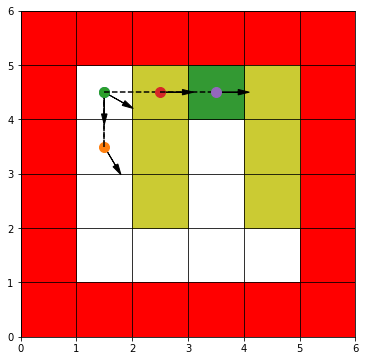

Trajectory ([state, action]) from (1, 4, 6) to the goal is:  [[(1, 4, 6), (1, -1)], [(1, 3, 5), (2, -1)], [(1, 4, 4), (1, -1)], [(2, 4, 3), (1, 0)], [(3, 4, 3), (1, 0)]]


In [8]:
# Problem 3(b)
def generate_trajectory(policy, s, pe=0.0, show=True):
    """
    Generate a trajectory using policy from initial state s to the goal and
    visualize the trajectory on the grid world.
    
    Args:
        Policy: a directionary including all states and their related action.
        Initial state s = (x, y, h).
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
    
    Returns:
        Trajectory including passing states and actions on each state
    """
    
    # Confirm the feasibility of p_e
    if not (pe >= 0.0 and pe <= 0.5):
        raise ValueError('The error probability must be between 0 and 0.5')
        
    # Generate the trajectory
    traj = []
    s_now = s
    while True:
        traj.append([s_now, policy[s_now]])
        if (policy[s_now] == (0, 0)):
            break
        if (s_now[0] == 3) and (s_now[1] == 4):
            break
        P_state = next_state(s_now, policy[s_now], pe)
        state_index = max(P_state.keys())
        s_next = P_state[state_index]
        s_now = s_next
        
    # Grid world initilization
    fig = plt.figure(figsize = (L,W))
    ax = fig.add_subplot(1,1,1)
    plt.xlim((0, L))
    plt.ylim((0, W))
    plt.grid(True, color = 'k')

    # Plot red markers at edges
    edge1 = plt.Rectangle((0,0), 1, 6, color = 'r')
    edge2 = plt.Rectangle((1,0), 5, 1, color = 'r')
    edge3 = plt.Rectangle((5,1), 1, 5, color = 'r')
    edge4 = plt.Rectangle((1,5), 4, 1, color = 'r')
    ax.add_patch(edge1)
    ax.add_patch(edge2)
    ax.add_patch(edge3)
    ax.add_patch(edge4)

    # Plot yellow markers
    yellow1 = plt.Rectangle((2,2), 1, 3, color = 'y', alpha = 0.8)
    yellow2 = plt.Rectangle((4,2), 1, 3, color = 'y', alpha = 0.8)
    ax.add_patch(yellow1)
    ax.add_patch(yellow2)

    # Plot green goal
    goal = plt.Rectangle((3,4), 1, 1, color = 'g', alpha = 0.8)
    ax.add_patch(goal)

    # Plot the start state
    plt.plot(s[0]+0.5, s[1]+0.5, 'o', markersize = '10')
    ax.arrow(s[0]+0.5, s[1]+0.5, 0.4*np.sin(30*s[2]*np.pi/180),0.4*np.cos(30*s[2]*np.pi/180), \
             head_width = 0.1, head_length = 0.2, fc = 'k', ec = 'k')
    
    # Plot all passing states
    for i in range(1, len(traj)):
        x1 = traj[i-1][0][0]
        y1 = traj[i-1][0][1]
        x2 = traj[i][0][0]
        y2 = traj[i][0][1]
        h = traj[i][0][2]
        plt.plot([x1+0.5, x2+0.5], [y1+0.5, y2+0.5], 'k--')
        plt.plot(x2+0.5, y2+0.5, 'o', markersize = '10')
        ax.arrow(x2+0.5, y2+0.5, 0.4*np.sin(30*h*np.pi/180),0.4*np.cos(30*h*np.pi/180), \
                 head_width = 0.1, head_length = 0.2, fc = 'k', ec = 'k')
    
    if show:
        plt.show()
        
    return traj
    
# Problem 3(c)
s0 = (1, 4, 6)
traj_sample = generate_trajectory(policy, s0, pe=0.0, show=True)
print("Trajectory ([state, action]) from %s to the goal is: " % str(s0), traj_sample)

In [9]:
# Problem 3(d)
def policy_eval(policy, reward_fn=reward, pe=0.0, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy
    
    Args:
        policy: {S: A} shaped dictionary representing the policy.
        reward_fn: reward function to be used for policy evaluation.
        discount_factor: Gamma discount factor.
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
        theta: We stop evaluation once our value function change is less than theta for all states.
        
    Returns:
        Dictionary of shape {S: V} representing the value function.
    """
    # Start with a random (all 0) value function
    V = {}
    for s in S:
        V[s] = 0.0
    
    while True:
        delta = 0
        # For each state, perform the evaluation
        for s in S:
            v = 0
            # Look at the possible next states
            P_state = next_state(s, policy[s], pe)
            for prob in P_state.keys():
                # Calculate the expected value
                s_next = P_state[prob]
                v = v + prob * (reward_fn(s_next) + discount_factor * V[s_next])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return V

# Problem 3(e)
V = policy_eval(policy, discount_factor=0.9, theta=0.00001)
s0 = (1, 4, 6)
print("The value V(s0) is:", V[s0])

The value V(s0) is: -604.4219191669506


In [10]:
# Problem 3(f)
def one_step_lookahead(V, reward_fn=reward, pe=0.0, discount_factor=1.0):
    """
    Function to compute a optimal policy given just one-step lookhead on value V
    
    Args:
        V: the evaluation value based on current policy
        reward_fn: reward function to be used for policy evaluation.
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
        discount_factor: Gamma discount factor.
        
    Returns:
        policy: dictionary including optimal policy so far given a one-step lookhead
    """
    policy = {}
    # Look at all states
    for s in S:
        action_values = np.zeros(nA)
        # Look at the possible next actions
        for i, a in enumerate(A):
            # For each action, look at the possible next states
            P_state = next_state(s, a, pe)
            for prob in P_state.keys():
                s_next = P_state[prob]
                # Calculate the expected value
                action_values[i] += prob * (reward_fn(s_next) + discount_factor * V[s_next])
                #action_values[i] += prob * discount_factor * V[s_next]
                
        # Find the best action by one-step lookahead
        best_a_index = np.argmax(action_values)
        policy[s] = A[best_a_index]
        
    return policy

In [11]:
# Problem 3(g)
def policy_iteration(policy, reward_fn=reward, pe=0.0, discount_factor=1.0):
    """
    Policy Iteration Algorithm.
    
    Args:
        policy: initial policy used to iterate
        reward_fn: reward function to be used for policy evaluation.
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function
    """
        
    while True:
        # Evaluate the current policy
        V = policy_eval(policy, reward_fn, pe, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # Update policy by one-step lookahead
        policy_updated = one_step_lookahead(V, reward_fn, pe, discount_factor)
        
        if policy_updated != policy:
            policy_stable = False
            
        policy = policy_updated
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

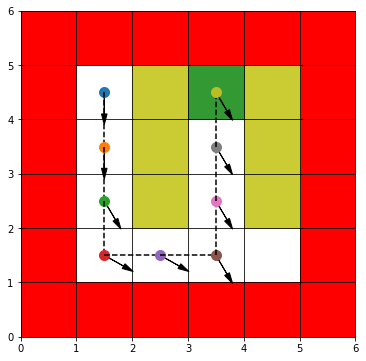

Execution time of Policy Iteration = 5.281501770019531 s
Trajectory ([state, action]) from (1, 4, 6) to the goal is:  [[(1, 4, 6), (1, 0)], [(1, 3, 6), (1, -1)], [(1, 2, 5), (1, -1)], [(1, 1, 4), (1, 0)], [(2, 1, 4), (1, 1)], [(3, 1, 5), (2, 0)], [(3, 2, 5), (2, 0)], [(3, 3, 5), (2, 0)], [(3, 4, 5), (0, 0)]]


In [12]:
# Problem 3(h) and Problem 3(i)
import time

# Compute the optimal policy
start_time = time.time()
policy_optimal, V_optimal = policy_iteration(policy, pe =0.0, discount_factor=0.9)

# Recompute and plot the trajectory under this optimal policy
s0 = (1, 4, 6)
traj = generate_trajectory(policy_optimal, s0, pe=0.0, show=True)
end_time = time.time()
print("Execution time of Policy Iteration = %s s" %str(end_time - start_time))
print("Trajectory ([state, action]) from %s to the goal is: " % str(s0), traj)

In [12]:
# Problem 4(a)
def value_iteration(policy, reward_fn=reward, pe=0.0, discount_factor=1.0, theta=0.0001):
    """
    Value Iteration Algorithm.
    
    Args:
        policy: initial policy used to iterate.
        reward_fn: reward function to be used for policy evaluation.
        p_e: the error probability Pe to pre-rotate when chosing to move. 0 < Pe <= 0.5
        discount_factor: Gamma discount factor.
        theta: We stop evaluation once our value function change is less than theta for all states.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function
    """
    # Start with a random (all 0) value function
    V = {}
    for s in S:
        V[s] = 0.0
        
    while True:
        # Stopping condition
        delta = 0
        # Update each state
        for s in S:
            action_values = np.zeros(nA)
            # Look at the possible next actions
            for i, a in enumerate(A):
                # For each action, look at the possible next states
                P_state = next_state(s, a, pe)
                for prob in P_state.keys():
                    s_next = P_state[prob]
                    # Calculate the expected value
                    action_values[i] += prob * (reward_fn(s_next) + discount_factor * V[s_next])
            # Find best action by doing a one-step lookahead
            best_action_value = np.max(action_values)
            best_action_index = np.argmax(action_values)
            policy[s] = A[best_action_index] 

            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function
            V[s] = best_action_value

        # Check if we can stop
        if delta < theta:
            break
    return policy, V        

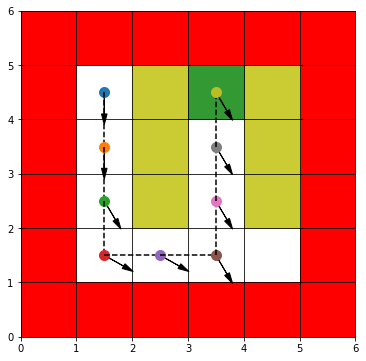

Execution time of Value Iteration = 3.1343929767608643 s
Trajectory ([state, action]) from (1, 4, 6) to the goal is:  [[(1, 4, 6), (1, 0)], [(1, 3, 6), (1, -1)], [(1, 2, 5), (1, -1)], [(1, 1, 4), (1, 0)], [(2, 1, 4), (1, 1)], [(3, 1, 5), (2, 0)], [(3, 2, 5), (2, 0)], [(3, 3, 5), (2, 0)], [(3, 4, 5), (0, 0)]]


In [14]:
# Problem 4(b) and Problem 4(c)
import time

# Compute the optimal policy
start_time = time.time()
policy_optimal, V_optimal = value_iteration(policy, pe =0.0, discount_factor=0.9)

# Recompute and plot the trajectory under this optimal policy
s0 = (1, 4, 6)
traj = generate_trajectory(policy_optimal, s0, pe=0.0, show=True)
end_time = time.time()
print("Execution time of Value Iteration = %s s" %str(end_time - start_time))
print("Trajectory ([state, action]) from %s to the goal is: " % str(s0), traj)

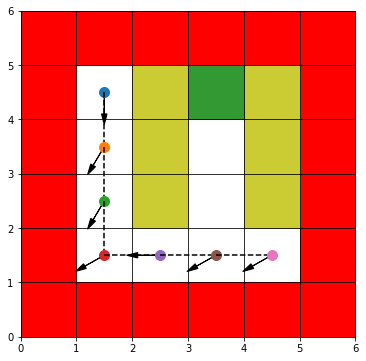

Trajectory ([state, action]) from (1, 4, 6) to the goal is:  [[(1, 4, 6), (1, 1)], [(1, 3, 7), (1, 0)], [(1, 2, 7), (1, 1)], [(1, 1, 8), (2, 1)], [(2, 1, 9), (2, -1)], [(3, 1, 8), (2, 0)], [(4, 1, 8), (0, 0)]]
Value in state (1, 4, 6) is 0.11939863366883982


In [13]:
# Problem 5(a)
# Set Error Probability to 25%
policy_optimal, V_optimal = value_iteration(policy, pe=0.25, discount_factor=0.9)
s0 = (1, 4, 6)
traj3 = generate_trajectory(policy_optimal, s0, pe=0.25, show=True)
print("Trajectory ([state, action]) from %s to the goal is: " % str(s0), traj3)
print("Value in state %s is" % str(s0),V_optimal[s0])

When pe = 0, the trajectory is shown as follows:


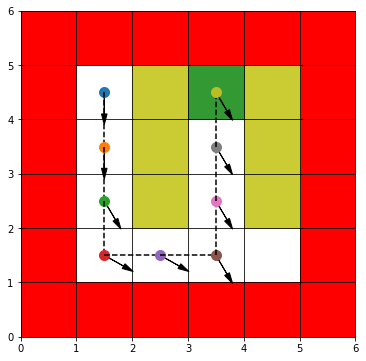

Trajectory ([state, action]) from (1, 4, 6) to the goal is:  [[(1, 4, 6), (1, 0)], [(1, 3, 6), (1, -1)], [(1, 2, 5), (1, -1)], [(1, 1, 4), (1, 0)], [(2, 1, 4), (1, 1)], [(3, 1, 5), (2, 0)], [(3, 2, 5), (2, 0)], [(3, 3, 5), (2, 0)], [(3, 4, 5), (0, 0)]]
Value in state (1, 4, 6) is 4.782351963480831


In [14]:
# Problem 5(b)

# Define a new reward function
def reward_new(s):
    # Border states (red)
    if (s[0] in [0, 5]) or (s[1] in [0, 5]):
        return -100
    
    # Lane Markers (yellow)
    elif (s[0] in [2, 4]) and (s[1] in [2, 3, 4]):
        return -10
    
    # Goal state (position (3,4) and pointing down)
    elif (s[0] == 3) and (s[1] == 4) and (s[2] in [5, 6, 7]):
        return 1

    else:
        return 0
    
# When pe = 0.0
pe = 0.0
print("When pe = 0, the trajectory is shown as follows:")
policy_optimal, V_optimal = value_iteration(policy, reward_new, pe, discount_factor=0.9)
s0 = (1, 4, 6)
traj4 = generate_trajectory(policy_optimal, s0, pe, show=True)
print("Trajectory ([state, action]) from %s to the goal is: " % str(s0),traj4)
print("Value in state %s is" % str(s0),V_optimal[s0])

When pe = 25%, the trajectory is shown as follows:


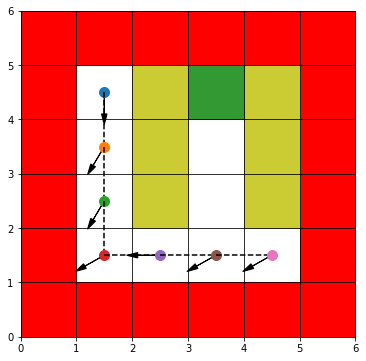

Trajectory ([state, action]) from (1, 4, 6) to the goal is:  [[(1, 4, 6), (1, 1)], [(1, 3, 7), (1, 0)], [(1, 2, 7), (1, 1)], [(1, 1, 8), (2, 1)], [(2, 1, 9), (2, -1)], [(3, 1, 8), (2, 0)], [(4, 1, 8), (0, 0)]]
Value in state (1, 4, 6) is 0.11117061422086838


In [15]:
# When pe = 25%
pe = 0.25
print("When pe = 25%, the trajectory is shown as follows:")
policy_optimal, V_optimal = value_iteration(policy, reward_new, pe, discount_factor=0.9)
s0 = (1, 4, 6)
traj5 = generate_trajectory(policy_optimal, s0, pe, show=True)
print("Trajectory ([state, action]) from %s to the goal is: " % str(s0),traj5)
print("Value in state %s is" % str(s0),V_optimal[s0])